<a href="https://colab.research.google.com/github/aleschiavo94/Sketches-Web-Search-Engine/blob/main/code/accuracy_assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import numpy as np
import time
import itertools
import os, shutil
import tensorflow as tf
import matplotlib.pyplot as plt

from random import random
from ipywidgets import Image
from numpy.linalg import norm
from IPython.display import display
from keras.models import Model
from sklearn.metrics import classification_report
from keras.callbacks import EarlyStopping, ModelCheckpoint

# tensorflow version 2.4.0
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, InceptionV3

In [ ]:
zip_path = '/content/gdrive/Shareddrives/COMPUTER_VISION/MIM_zipped.zip'
!cp "{zip_path}" .
!unzip -q MIM_zipped.zip
!rm MIM_zipped.zip

In [ ]:
test_images_per_class = 20 # le immagini sono al massimo 80
train_images_per_class = 80 - test_images_per_class

In [ ]:
BASE_DIR = "/content/content/gdrive/Shareddrives/COMPUTER_VISION/MIRCV"
SKETCHES_DIR = os.path.join(BASE_DIR, "sketches")
MIRFLICKR_DIR = os.path.join(BASE_DIR, "mirflickr/mirflickr25k")

print(os.listdir(os.path.join(SKETCHES_DIR, "png")))
def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)
      
copytree(f'{SKETCHES_DIR}/png', f'{SKETCHES_DIR}/all')

try:
  os.rename(f'{SKETCHES_DIR}/png', f'{SKETCHES_DIR}/train')
except:
  print('already renamed')

if not os.path.exists(f'{SKETCHES_DIR}/test'):
  os.mkdir(f'{SKETCHES_DIR}/test')
  for class_folder in os.listdir(f'{SKETCHES_DIR}/train'):
    if os.path.isdir(f'{SKETCHES_DIR}/train/{class_folder}'):
      images = os.listdir(f'{SKETCHES_DIR}/train/{class_folder}')
      os.mkdir(f'{SKETCHES_DIR}/test/{class_folder}')
      for i in range(test_images_per_class):
        os.rename(f'{SKETCHES_DIR}/train/{class_folder}/{images[i]}', f'{SKETCHES_DIR}/test/{class_folder}/{images[i]}')

['bookshelf', 'baseball bat', 'owl', 'basket', 'hot air balloon', 'tablelamp', 'fish', 'hot-dog', 'laptop', 'pretzel', 'nose', 'cigarette', 'mailbox', 'snake', 'computer monitor', 'pig', 'panda', 'sheep', 'octopus', 'radio', 'saxophone', 'floor lamp', 'couch', 'fan', 'sea turtle', 'rollerblades', 'bell', 'tiger', 'crane (machine)', 'bee', 'arm', 'car (sedan)', 'rifle', 'blimp', 'chandelier', 'banana', 'house', 'apple', 'book', 'swan', 'pumpkin', 'bed', 'hedgehog', 'canoe', 'mermaid', 'tooth', 'chair', 'pipe (for smoking)', 'parrot', 'grenade', 'donut', 'cup', 'santa claus', 'wheel', 'violin', 'camel', 'alarm clock', 'shovel', 'ashtray', 'standing bird', 'tent', 'mosquito', 'skateboard', 'bicycle', 'cloud', 'hat', 'flashlight', 'door', 'teddy-bear', 'tennis-racket', 'door handle', 'bush', 'wheelbarrow', 'lightbulb', 'mushroom', 'beer-mug', 'boomerang', 'parking meter', 'penguin', 'van', 'toothbrush', 'teacup', 'duck', 'motorbike', 'suv', 'monkey', 'vase', 'face', 'cow', 'snowman', 'trac

In [ ]:
def average_precision(requested_label, result_labels, n_ground_truth = 80):
  """
  label ricercata, label ottenute, il numero di oggetti che ci sono quella label
  """
  correct_array = (requested_label == result_labels).astype(int)
  precision_array = [np.mean(correct_array[:k]) for k in range(1, correct_array.shape[0] + 1)]
  # print(precision_array * correct_array) # mi rimangono solo quelli a 1
  return np.sum(precision_array * correct_array) / n_ground_truth


def mAP_per_label(index, features, n_queries = 250, n_labels = 250, img_per_labels = 80, mode = 'euclidean', check_first_label=True, n_ground_truth=None):
  sum = {}
  if not n_ground_truth:
    n_ground_truth = img_per_labels
  for i in range(n_queries):
    label = i % n_labels
    image_idx = ((i * img_per_labels) + int(random() * img_per_labels)) % (n_labels * img_per_labels)
    # print('QUERY')
    # print('index = ' + str(image_idx))
    # print('label =' + str(label))
    res = index.query(features[image_idx], n_ground_truth, mode = mode)
    if res is None:
      sum += 0
      continue
    # print('first label of resultset (must be equal to label) = ' + str(res['labels'][0]))
    if check_first_label:
      assert res['labels'][0] == label, 'deve essere della stessa label'
    a = average_precision(label, res['labels'], n_ground_truth)
    if sum.get(label) is None:
      sum[label] = 0
    sum[label] = sum[label] + a
  for key in sum:
    sum[key] = sum[key] / (n_queries / n_labels)
  return sum

In [ ]:
def extract_features(extractor, generator, sample_count, dim=2048):
  features = np.zeros((sample_count, dim)) #extractor output shape 
  i = 0
  for inputs_batch, labels_batch in generator:
    start = time.time()
    features_batch = extractor.predict(inputs_batch)
    start = time.time()
    if (i + 1) * BATCH_SIZE > sample_count:
      features[i * BATCH_SIZE : sample_count , :] = features_batch
      assert np.array_equal(np.argmax(labels_batch, axis = 1), generator.labels[i * BATCH_SIZE : sample_count]), 'LABELS NOT CORRESPONDING REINIZIALIZE GENERATOR'
    else:
      features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE, : ] = features_batch
      assert np.array_equal(np.argmax(labels_batch, axis = 1), generator.labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE]), 'LABELS NOT CORRESPONDING REINIZIALIZE GENERATOR'
    i += 1
    if i * BATCH_SIZE >= sample_count:
      break
  
  return features
  

In [ ]:
IMG_HEIGHT = 299
IMG_WIDTH = 299
INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
BATCH_SIZE = 64


sketches_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
mirflickr_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

sketches_generator_train = sketches_datagen.flow_from_directory(
      # This is the target directory
      SKETCHES_DIR + '/train',
      shuffle=False,
      target_size=(IMG_HEIGHT, IMG_WIDTH),
      batch_size=BATCH_SIZE)

mirflickr_generator = mirflickr_datagen.flow_from_directory(
        # This is the target directory
        MIRFLICKR_DIR,
        shuffle=False,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE)

sketches_generator_test = sketches_datagen.flow_from_directory(
      # This is the target directory
      SKETCHES_DIR + '/test',
      shuffle=False,
      target_size=(IMG_HEIGHT, IMG_WIDTH),
      batch_size=BATCH_SIZE)

Found 15000 images belonging to 250 classes.
Found 25000 images belonging to 1 classes.
Found 5000 images belonging to 250 classes.


In [ ]:
MODEL_PATH = "/content/gdrive/Shareddrives/COMPUTER_VISION/models"
model = models.load_model(MODEL_PATH + '/inception_finetuning_classification_3_last_one_more_train_all_parameters_more_train.h5')
extractor = Model(model.input, model.layers[-2].output)

In [ ]:
sketches_features_train = extract_features(extractor, sketches_generator_train, 15000, dim=2048)
sketches_features_test = extract_features(extractor, sketches_generator_test, 5000, dim=2048)
mirflickr_features = extract_features(extractor, mirflickr_generator, 25000, dim=2048)

# Assess model

In [ ]:
# Useful to have comparable performance
class NO_INDEX:
  def __init__(self):
    self.features = None
    self.ids = None
    self.labels = None

  def insert(self, features, ids, labels):
    assert features.shape[0] == len(ids), "mismatch between ids length and features"
    assert len(labels) == len(ids), "mismatch between ids length and labels"
    self.features = features
    self.ids = ids
    self.labels = labels
  
  def query(self, features, top_k, mode = 'euclidean', return_cost = False):
    assert mode in ['similarity', 'euclidean'], "mode must be similarity or euclidean"
    top_k += 1
    if mode == 'euclidean':
      dist = norm(self.features - np.array(features), axis=1)
      idx_partitioned = np.argpartition(dist, top_k - 1 if dist.shape[0] - 1 > top_k - 1 else dist.shape[0] - 1)
      k = {}
      # qua è più comodo avere array 1- dimensionali
      k['ids'] = self.ids[idx_partitioned].flatten()[:top_k - 1 if dist.shape[0] - 1 > top_k - 1 else dist.shape[0]]
      k['labels'] = self.labels[idx_partitioned].flatten()[:top_k - 1 if dist.shape[0] - 1 > top_k - 1 else dist.shape[0]]
      k['distances'] = dist[idx_partitioned][:top_k - 1 if dist.shape[0] - 1 > top_k - 1 else dist.shape[0]]
      
      idx_sorted = np.argsort(k['distances'])
      idx_sorted = idx_sorted
      k['distances'] = k['distances'][idx_sorted]
      k['ids'] = k['ids'][idx_sorted]
      k['labels'] = k['labels'][idx_sorted]
      if return_cost:
        return (k, dist.size)
      return k
    sim = np.sum(self.features * np.array(features), axis=1) / (norm(self.features, axis=1) * norm(np.array([features]), axis=1))
    idx_partitioned = np.argpartition(sim, -(top_k - 1) if sim.shape[0] - 1 > top_k - 1 else sim.shape[0] - 1)
    k = {}
    # qua è più comodo avere array 1- dimensionali
    if sim.shape[0] - 1 > top_k - 1:  
      idx_partitioned = idx_partitioned[-(top_k - 1):]

    k['ids'] = self.ids[idx_partitioned].flatten()
    k['labels'] = self.labels[idx_partitioned].flatten()
    k['similarities'] = sim[idx_partitioned]
    idx_sorted = np.argsort(k['similarities'])[::-1]
    idx_sorted = idx_sorted
    k['similarities'] = k['similarities'][idx_sorted]
    k['ids'] = k['ids'][idx_sorted]
    k['labels'] = k['labels'][idx_sorted]
    if return_cost:
      return (k, sim.size)
    return k
    

## mAP per class

In [ ]:
print('mAP on train')
no_index_base = NO_INDEX()
no_index_base.insert(np.vstack((sketches_features_train, mirflickr_features)), 
              np.concatenate((sketches_generator_train.filenames, mirflickr_generator.filenames)), 
              np.concatenate((sketches_generator_train.labels, np.array([250] * mirflickr_features.shape[0]))))
print('Euclidean mAP')
print(mAP_per_label(no_index_base, sketches_features_train, img_per_labels=train_images_per_class))
print('Cosine mAP')
print(mAP_per_label(no_index_base, sketches_features_train, mode = 'similarity', img_per_labels=train_images_per_class))
print('')

print('mAP using test as query on train')

print('Euclidean mAP')
print(mAP_per_label(no_index_base, sketches_features_test, 5000, img_per_labels=test_images_per_class, check_first_label=False, n_ground_truth=train_images_per_class))
print('Cosine mAP')
print(mAP_per_label(no_index_base, sketches_features_test, 5000, mode = 'similarity', img_per_labels=test_images_per_class, check_first_label=False, n_ground_truth=train_images_per_class))
print('')


del no_index_base

mAP on train
Euclidean mAP
{0: 0.38482204401932163, 1: 0.7838800993730073, 2: 0.39809673299083276, 3: 0.031767676767676764, 4: 0.8473486618056701, 5: 0.12873027618041272, 6: 0.2957095867846841, 7: 0.01875, 8: 0.8396038651559895, 9: 0.4585360645536076, 10: 0.5000423144806632, 11: 0.22680596486803153, 12: 0.8234438465780236, 13: 0.46414372748521676, 14: 0.07133500557413601, 15: 0.17672664520798692, 16: 0.07657372737271456, 17: 0.016666666666666666, 18: 0.07183195801525584, 19: 0.7511266119903776, 20: 0.20094854870799594, 21: 0.3827849587233155, 22: 0.36027766615865164, 23: 0.09836407939039518, 24: 0.47389535097586466, 25: 0.4650587404015293, 26: 0.7596252205569922, 27: 0.6239257178589717, 28: 0.01916666666666667, 29: 0.5172872918783917, 30: 0.19589757427869917, 31: 0.04654794386758871, 32: 0.07220076431746912, 33: 0.8247985243755775, 34: 0.09797979797979799, 35: 0.8194644488570223, 36: 0.17994225145709672, 37: 0.7651250427077123, 38: 0.043950807510129544, 39: 0.43008906377236467, 40: 0.7

In [ ]:
# 20 queries per class (250*20 = 5000) first run

no_index_base = NO_INDEX()
no_index_base.insert(np.vstack((sketches_features_train, mirflickr_features)), 
              np.concatenate((sketches_generator_train.filenames, mirflickr_generator.filenames)), 
              np.concatenate((sketches_generator_train.labels, np.array([250] * mirflickr_features.shape[0]))))

print('mAP on train')
print('Euclidean mAP')
print(mAP_per_label(no_index_base, sketches_features_train, 5000, img_per_labels=train_images_per_class))
print('Cosine mAP')
print(mAP_per_label(no_index_base, sketches_features_train, 5000, mode = 'similarity', img_per_labels=train_images_per_class))
print('')

print('mAP using test as query on train')

print('Euclidean mAP')
print(mAP_per_label(no_index_base, sketches_features_test, 5000, img_per_labels=test_images_per_class, check_first_label=False, n_ground_truth=train_images_per_class))
print('Cosine mAP')
print(mAP_per_label(no_index_base, sketches_features_test, 5000, mode = 'similarity', img_per_labels=test_images_per_class, check_first_label=False, n_ground_truth=train_images_per_class))
print('')


mAP on train
Euclidean mAP
{0: 0.41653948885272607, 1: 0.5181348972504611, 2: 0.3404292274106406, 3: 0.45706896427105315, 4: 0.6550197876781823, 5: 0.38875840312436466, 6: 0.1109792143869841, 7: 0.1362382454605243, 8: 0.49943853116755543, 9: 0.519441303426431, 10: 0.2860833825860482, 11: 0.21909240329474353, 12: 0.5237084931782807, 13: 0.2501863924195347, 14: 0.18082417371079898, 15: 0.08065150128126881, 16: 0.09194052084105545, 17: 0.40440859384134853, 18: 0.21148339438190167, 19: 0.6540657816893309, 20: 0.15176283762277937, 21: 0.6496589935741851, 22: 0.3314525187727759, 23: 0.44677607657708707, 24: 0.4199233826197425, 25: 0.2162637010659577, 26: 0.7164379902826586, 27: 0.3416371483458332, 28: 0.5994164065828917, 29: 0.4225669160734059, 30: 0.1050489757119529, 31: 0.1644044674350533, 32: 0.15897289856228095, 33: 0.3716115340975566, 34: 0.07527141397193873, 35: 0.5486017381299376, 36: 0.2641440013297104, 37: 0.4271858675229492, 38: 0.1778458606358665, 39: 0.5372058647010978, 40: 0.466

In [ ]:
# 20 queries per class (250*20 = 5000) second run

print('mAP on train')
print('Euclidean mAP')
print(mAP_per_label(no_index_base, sketches_features_train, 5000, img_per_labels=train_images_per_class))
print('Cosine mAP')
print(mAP_per_label(no_index_base, sketches_features_train, 5000, mode = 'similarity', img_per_labels=train_images_per_class))
print('')

print('mAP using test as query on train')

print('Euclidean mAP')
print(mAP_per_label(no_index_base, sketches_features_test, 5000, img_per_labels=test_images_per_class, check_first_label=False, n_ground_truth=train_images_per_class))
print('Cosine mAP')
print(mAP_per_label(no_index_base, sketches_features_test, 5000, mode = 'similarity', img_per_labels=test_images_per_class, check_first_label=False, n_ground_truth=train_images_per_class))
print('')

del no_index_base

mAP on train
Euclidean mAP
{0: 0.3200195145526438, 1: 0.7075410674518453, 2: 0.3291976035978025, 3: 0.3565843540010328, 4: 0.7086878579042903, 5: 0.42640858744698146, 6: 0.12234204104949102, 7: 0.15966820627290704, 8: 0.5417034017963875, 9: 0.4701038987420053, 10: 0.33096190851990276, 11: 0.2592678698305366, 12: 0.47046235482123827, 13: 0.14029124850733926, 14: 0.2423185867999214, 15: 0.20085556369664012, 16: 0.08485398865881422, 17: 0.33234747779153895, 18: 0.24831106243672435, 19: 0.5783162624507633, 20: 0.25320618541830303, 21: 0.5881590782085337, 22: 0.33499828292009337, 23: 0.4907619312973367, 24: 0.26773540396500306, 25: 0.19048076764527686, 26: 0.6518423582982317, 27: 0.36095787527601625, 28: 0.6193359035106646, 29: 0.30894174009759523, 30: 0.07958513153610988, 31: 0.14127898805525804, 32: 0.13321150847130223, 33: 0.6079949721203538, 34: 0.1114447820921463, 35: 0.48812586450892576, 36: 0.22958423577644577, 37: 0.504853557023187, 38: 0.07543916534458946, 39: 0.5869744136543531, 4

## Accuracy per class

In [ ]:
acc_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_images_per_class = 20 # le immagini sono al massimo 80
train_images_per_class = 80 - test_images_per_class

train_generator = acc_datagen.flow_from_directory(
  SKETCHES_DIR + "/train/",
  shuffle=False,
  target_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=train_images_per_class)

test_generator = acc_datagen.flow_from_directory(
  SKETCHES_DIR + '/test/',
  shuffle=False,
  target_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=test_images_per_class)

train_accuracies = []
test_accuracies = []
class_counter = 0

# training accuracies
for images_batch, labels_batch in train_generator:
  class_counter += 1
  #print('Train Accuracy')

  if class_counter == 251:
    class_counter = 0
    break

  res = model.evaluate(images_batch,
                      labels_batch,
                      return_dict=True,
                      verbose=0)

  train_accuracies.append(res["acc"])

# test accuracies 
for images_batch, labels_batch in test_generator:
  class_counter += 1
  #print('Test Accuracy')

  if class_counter == 251:
    class_counter = 0
    break

  res = model.evaluate(images_batch,
                      labels_batch,
                      return_dict=True,
                      verbose=0)

  test_accuracies.append(res["acc"])

Found 15000 images belonging to 250 classes.
Found 5000 images belonging to 250 classes.


In [ ]:
# verifico che la mean test acc sia 0.70
print(np.mean(test_accuracies))

0.8087333334684372
0.709


In [ ]:
zipped = zip(train_accuracies, test_accuracies)
acc_by_class = []

for item in enumerate(zipped):  
  tmp = {}
  tmp["class label"] = item[0]
  tmp["train Acc"] = item[1][0]
  tmp["test Acc"] = item[1][1]

  acc_by_class.append(tmp)

# sort dict by decreasing value of test accuracy 
from operator import itemgetter
acc_by_class_s = sorted(acc_by_class, key=itemgetter('class label')) 

# save results on file 
import json
filepath = "/content/gdrive/Shareddrives/COMPUTER_VISION/analysis_by_class/class_accuracies"
print(filepath)
with open(filepath, 'w') as fout:
  json.dump(acc_by_class_s, fout, indent=4)

/content/gdrive/Shareddrives/COMPUTER_VISION/analysis_by_class/class_accuracies


## Correlation Analysis: Scatter Plot. (mAP vs Accuracy)


In [ ]:
import json

#read accuracies vector 
x = []
lbls = []
filepath = "/content/gdrive/Shareddrives/COMPUTER_VISION/analysis_by_class/class_accuracies"
f = open(filepath,) 
data = json.load(f)   
for item in data: 
    x.append(item["test Acc"]) 
    lbls.append(item["class label"])
f.close() 

#read mAP vector 
y = []
filepath = "/content/gdrive/Shareddrives/COMPUTER_VISION/analysis_by_class/mAP_by_class"
f = open(filepath,) 
data = json.load(f)   
for item in data: 
    y.append(item["mAP"])
f.close() 

In [ ]:
print(len(x))
print(len(y))
print(len(lbls))

250
250
250


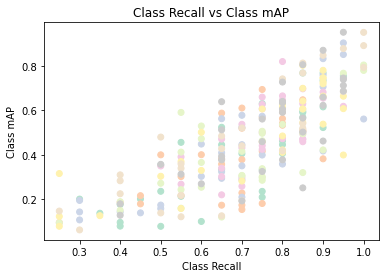



Correlation coefficient: 0.7863


In [ ]:
import matplotlib.pyplot as plt

colors = ['#2300A8', '#00A658']
plt.scatter(x, y, c=lbls, cmap="Pastel2")
plt.title("Class Recall vs Class mAP")
plt.xlabel("Class Recall")
plt.ylabel("Class mAP");
plt.show()

print("\n")
print(f"Correlation coefficient: {round(np.corrcoef(x,y)[0][1], 4)}")

## Get worst classes misclassifications

In [ ]:
def get_misclassifications(class_label):
  acc_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

  test_images_per_class = 20 # le immagini sono al massimo 80

  test_generator = acc_datagen.flow_from_directory(
    SKETCHES_DIR + '/test/',
    shuffle=False,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=test_images_per_class)

  class_counter = 0

  # test accuracies 
  for images_batch, labels_batch in test_generator:

    # only want dog class predictions 
    if class_counter == class_label:
      predictions = model.predict(images_batch)
      break

    class_counter += 1
  return predictions

In [ ]:
dog_pred = get_misclassifications(66)
print(len(dog_pred))

Found 5000 images belonging to 250 classes.
20


In [ ]:
class_predicted = []
for prediction in dog_pred:
  class_predicted.append(np.argmax(prediction))

print(class_predicted)

[131, 66, 101, 66, 106, 106, 131, 66, 59, 106, 66, 66, 143, 175, 131, 143, 123, 66, 106, 223]


In [ ]:
# dog is mostly misclassified as horse (4 times)
unique, counts = np.unique(class_predicted, return_counts=True)
print(unique, counts)

[ 59  66 101 106 123 131 143 175 223] [1 6 1 4 1 3 2 1 1]


In [ ]:
loudspeaker_pred = get_misclassifications(125)
print(len(loudspeaker_pred))

Found 5000 images belonging to 250 classes.
20


In [ ]:
class_predicted = []
for prediction in loudspeaker_pred:
  class_predicted.append(np.argmax(prediction))

print(class_predicted)

[216, 127, 125, 127, 127, 177, 127, 113, 8, 125, 125, 125, 125, 113, 113, 125, 125, 125, 125, 110]


In [ ]:
# loudspeaker is mostly misclassified as megaphone (4 times)
unique, counts = np.unique(class_predicted, return_counts=True)
print(unique, counts)

[  8 110 113 125 127 177 216] [1 1 3 9 4 1 1]
